# 试手MNIST数据集
## （手写数字数据集）

In [45]:
import numpy as np
from sklearn.datasets import fetch_openml 
##使用fetch_openml，可以非常方便的从机器学习网站中下载各种数据集

from sklearn.datasets import fetch_openml  
mnist = fetch_openml("mnist_784")  

In [2]:
## mnist数据集是字典的形式，下面对数据集进行分离
X, y = mnist['data'] ,mnist['target']
X.shape

(70000, 784)

In [3]:
X_train = np.array(X[:60000],dtype=float)
y_train = np.array(y[:60000], dtype=float)
X_test = np.array(X[60000:], dtype=float)
y_test = np.array(y[60000:], dtype=float)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

### 使用KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
#%time knn_clf.fit(X_train , y_train) ## 把数据使用树结构进行存储
#大概需要32.3s

Wall time: 32.3 s


KNeighborsClassifier()

In [8]:
## knn 的预测过程是很慢的，需要比对所有数据找到前K个近的数据，再进行投票
%time knn_clf.score(X_test , y_test)
#大概需要8min 10s , 得分为0.9688

Wall time: 8min 10s


0.9688

#### 之前讲的使用knn前最好对数据进行归一化处理
#### 为什么上面没有对数据进行归一化处理？？
#### 原因是上面的数据整体都表示图像中的像素点，整体都处于同一个尺度下

### PCA进行降维

In [9]:
from sklearn.decomposition import PCA

pca = PCA(0.9) ##只保留90%的信息
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
X_train_reduction.shape  
##此时，维度从784维降到87维，但确保留了原数据90%的信息

(60000, 87)

In [12]:
knn_clf = KNeighborsClassifier()
%time knn_clf.fit(X_train_reduction , y_train)

Wall time: 1.33 s


KNeighborsClassifier()

In [13]:
X_test_reduction = pca.transform(X_test)
%time knn_clf.score(X_test_reduction , y_test)
## 此时，我们使用PCA降维后的时间减少了，预测率反而提高了

Wall time: 1min 3s


0.9728

#### 使用PCA进行降维，是丢失了一些信息，为什么预测率反而提高了？
#### PCA不仅仅是对原有的数据进行降维，更有可能降低了噪音

# 使用PCA降噪

#### 回忆之前的例子

In [26]:
import numpy as np
import matplotlib.pyplot as plt

X = np.empty((100,2))
X[:,0] = np.random.uniform(0.,100.,size=100)  ### X 有两个特征，两个特征之间有线性关系
X[:,1] = 0.75 *X[:,0] + 3. + np.random.normal(0.,5.,size=100)

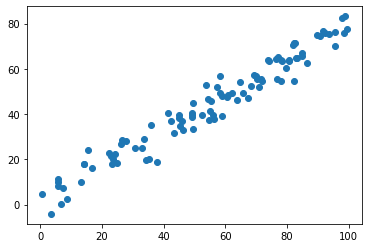

In [27]:
plt.scatter(X[:,0] , X[:,1])
plt.show()

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)   
pca.fit(X)
X_reduction = pca.transform(X)            ##从两维降到一维
X_restore = pca.inverse_transform(X_reduction) ##再从一维恢复到二维，此时的数据将原有的噪音给去除了

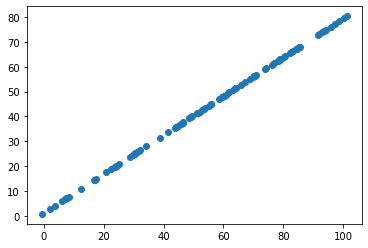

In [29]:
plt.scatter(X_restore[:,0] , X_restore[:,1])
plt.show()

#### 使用PCA会丢失一部分信息，但是丢失的大部分信息是噪音，所以可能进行降维反而提高了准确度

#### 手写识别的例子

In [30]:
from sklearn import datasets
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [31]:
## 给X增加噪音矩阵，均值为0，方差为1，矩阵形状和X相同
noisy_digits = X + np.random.normal(0,4,size=X.shape)

In [32]:
##小例子
example_digits = noisy_digits[y==0,:][:10] #从y=0的列取前十个
for num in range(1,10):
    X_num = noisy_digits[y==num,:][:10]
    example_digits = np.vstack([example_digits , X_num])
example_digits.shape
## 一共100个样本，分别是0-9这十个数字，每个数字对应10个样本

(100, 64)

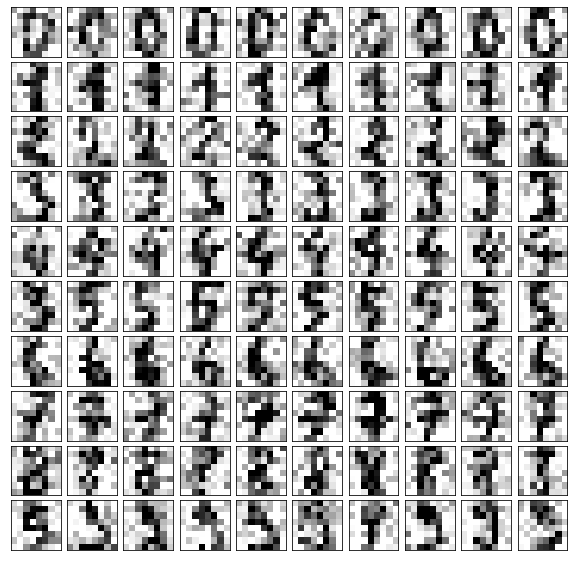

In [33]:
def plot_digits(data):
    fig, axes = plt.subplots(10,10,figsize=(10,10),
                             subplot_kw={'xticks':[] , 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1 , wspace=0.1))
    for i,ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8,8),cmap='binary',
                  interpolation='nearest',clim=(0,16))

plot_digits(example_digits)
## 下图中的噪音非常明显，根本看不清数字

In [34]:
##使用pca降噪
pca = PCA(0.5)
pca.fit(noisy_digits)
pca.n_components_  ##保留50%的数据，需要降到12维

12

In [36]:
compontents = pca.transform(example_digits) ##降到12维
filtered_digits = pca.inverse_transform(compontents)##回到64维
# 此时数据中的造影已经消除了

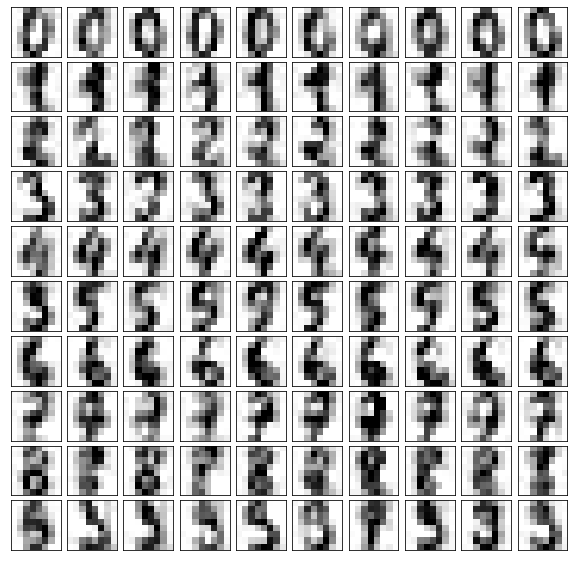

In [37]:
plot_digits(filtered_digits)

# 人脸识别与特征脸

![title](../img/19.png)

#### X的每一行表示一张脸，W的每一行表示一个特征脸
#### 每一个特征脸对应的是一个主成分

In [38]:
from sklearn.datasets import fetch_lfw_people

In [39]:
faces = fetch_lfw_people()   ##下载数据集，需要一段时间

In [40]:
faces.keys() ##查看属性

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [41]:
faces.data.shape  ##13233个人脸，每张脸对应2914个属性

(13233, 2914)

In [43]:
faces.images.shape  # 图像大小是62*47=2914

(13233, 62, 47)

In [51]:
##打乱样本顺序，再取出36张脸
random_indexes = np.random.permutation(len(faces.data)) ##对索引进行随机排列
X = faces.data[random_indexes]  ## X表示13233个样本脸被打乱顺序
example_faces = X[:36,:]
example_faces.shape

(36, 2914)

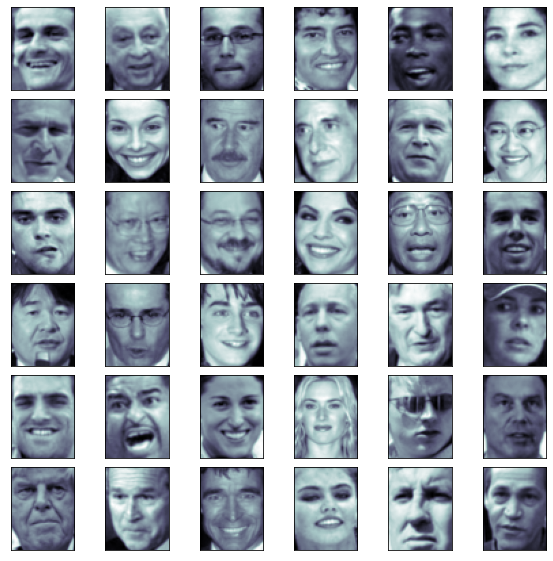

In [53]:
def plot_faces(faces):
    fig, axes = plt.subplots(6,6,figsize=(10,10),
                             subplot_kw={'xticks':[] , 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1 , wspace=0.1))
    for i,ax in enumerate(axes.flat):
        ax.imshow(faces[i].reshape(62,47),cmap='bone')
    plt.show()

plot_faces(example_faces)

In [56]:
print(faces.target_names)        ##人名
print(len(faces.target_names))  ##数据库中的人数

['AJ Cook' 'AJ Lamas' 'Aaron Eckhart' ... 'Zumrati Juma' 'Zurab Tsereteli'
 'Zydrunas Ilgauskas']
5749


### 特征脸

In [57]:
%%time
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized')   ##使用随机的方式求PCA。由于数据库较大，这种方式会快一点
pca.fit(X)

Wall time: 29.3 s


PCA(svd_solver='randomized')

In [58]:
pca.components_.shape   ##代表2914个主成分，每个主成分对应一个2914的向量

(2914, 2914)

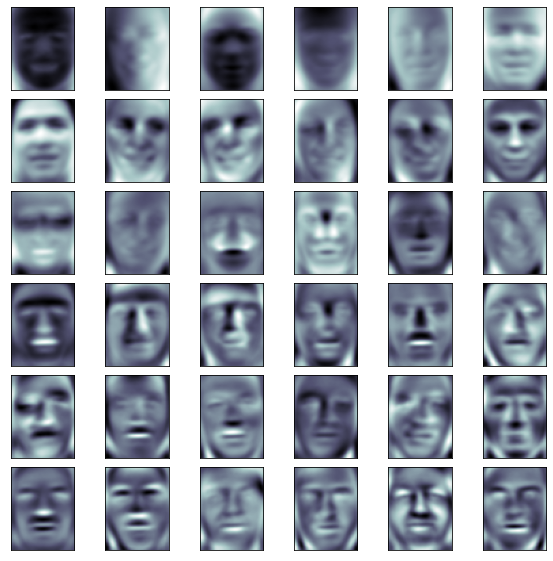

In [59]:
plot_faces(pca.components_[:36,:]) ##绘制前36个出主成分，也就是特征脸
###每张人脸都是特征脸的线性组合

In [60]:
## 60表示，从里面取出同一个人至少有60张脸的图片
faces2 = fetch_lfw_people(min_faces_per_person=60)

In [61]:
print(faces2.data.shape)
print(faces2.target_names) ##只有8个人的脸图，每人的脸图有60张以上

(1348, 2914)
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


# 多项式回归
# 本质是先增加样本的特征，之后依然使用线性回归

#### 线性回归要求：数据本身存在线性关系，但是实际应用场景中，具有线性关系的数据是很少的
#### 所以，我们改进线性回归法，使它可以处理非线性数据
#### 进而，引出模型泛化的概念

In [5]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.uniform(-3,3,size=100)   #100个数据，-3到3之间随机取值
X = x.reshape(-1,1)

y = 0.5 * x**2 + x + 2 + np.random.normal(0,1,size=100)

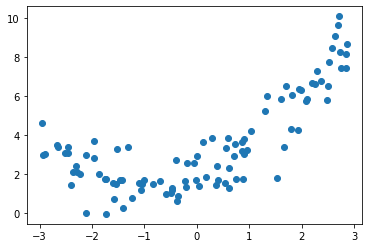

In [6]:
plt.scatter(x,y)

In [7]:
## 先使用线性回归的方式来拟合数据集
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression()

In [6]:
y_predict = lin_reg.predict(X)

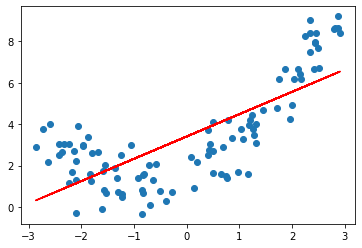

In [7]:
plt.scatter(x,y)
plt.plot(x,y_predict,color='r')
# 显然直线拟合的不好

In [8]:
## 解决方案：给X添加一个特征   
X2 = np.hstack([X , X**2])
X2.shape  

(100, 2)

In [9]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X2 , y)
y_predict2 = lin_reg2.predict(X2)

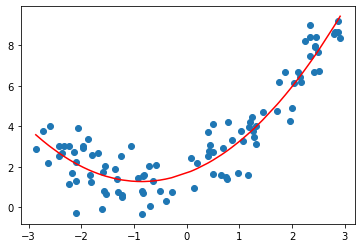

In [11]:
plt.scatter(x,y)
plt.plot(np.sort(x),y_predict2[np.argsort(x)],color='r')
##注意：我们生成的x是没有顺序的,需要对x进行排序才能生成一条平滑的线

In [13]:
lin_reg2.coef_   ##查看系数，第一个是X前面的系数为1，第二个是X**2前面的系数为0.5

array([0.98888906, 0.57507143])

In [14]:
lin_reg2.intercept_  ##查看截距，原来设置的为2

1.6961504694497018

#### 多项式回归的思路与PCA的不同，PCA是对数据降维处理，
#### 多项式回归是对数据升维，添加了一些新的特征后，使得算法可以更好的拟合高维度的数据

# scikit-learn 中的多项式回归和Pipeline

In [8]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.uniform(-3,3,size=100)   #100个数据，-3到3之间随机取值
X = x.reshape(-1,1)
y = 0.5 * x**2 + x + 2 + np.random.normal(0,1,size=100)

In [9]:
## 多项式回归主要是数据的预处理，为数据添加一些新的特征
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)  ## 给X添加一个二次幂的特征
poly.fit(X)
X2 = poly.transform(X)
X2[:5,:]   ##看一下前5行，第一列将入1，第二列是X的一次方，第三列是X的二次方

array([[ 1.        , -1.11571432,  1.24481844],
       [ 1.        ,  1.81973592,  3.31143883],
       [ 1.        , -1.24921416,  1.56053603],
       [ 1.        ,  0.21178949,  0.04485479],
       [ 1.        ,  1.34802925,  1.81718286]])

In [10]:
from sklearn.linear_model import LinearRegression
lin_reg2 = LinearRegression()
lin_reg2.fit(X2,y)
y_predict2 = lin_reg2.predict(X2)

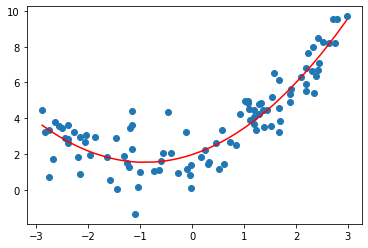

In [25]:
plt.scatter(x,y)
plt.plot(np.sort(x),y_predict2[np.argsort(x)],color='r')
##注意：我们生成的x是没有顺序的,需要对x进行排序才能生成一条平滑的线

In [26]:
lin_reg2.coef_   ##查看系数

array([0.        , 0.956263  , 0.52741912])

In [27]:
lin_reg2.intercept_  ##查看截距

1.9655187076050047

### 关于PolynomialFeatures

In [29]:
## X中有两个特征
X = np.arange(1,11).reshape(-1,2)
X

array([[ 1,  2],
       [ 3,  4],
       [ 5,  6],
       [ 7,  8],
       [ 9, 10]])

In [31]:
poly = PolynomialFeatures(degree=2)  ## 给X添加一个二次幂的特征,是呈指数增长的
poly.fit(X)
X2 = poly.transform(X)
X2

array([[  1.,   1.,   2.,   1.,   2.,   4.],
       [  1.,   3.,   4.,   9.,  12.,  16.],
       [  1.,   5.,   6.,  25.,  30.,  36.],
       [  1.,   7.,   8.,  49.,  56.,  64.],
       [  1.,   9.,  10.,  81.,  90., 100.]])

### Pipeline 管道

In [18]:
x = np.random.uniform(-3,3,size=100)   #100个数据，-3到3之间随机取值
X = x.reshape(-1,1)
y = 0.5 * x**2 + x + 2 + np.random.normal(0,1,size=100)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

###实例化Pipeline ，创建管道（方便我们一次调用）
poly_reg = Pipeline([                        
    ('poly', PolynomialFeatures(degree=2)),     ##第一步：多项式特征
    ('std_scaler', StandardScaler()),           ##第二步：数值均一化
    ('lin_reg', LinearRegression())             ##第三步：线性回归
])

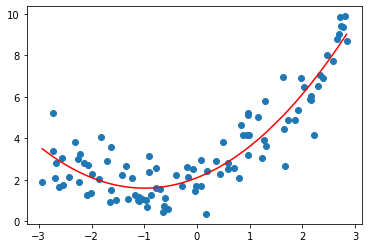

In [20]:
poly_reg.fit(X,y)
y_predict = poly_reg.predict(X)

plt.scatter(x,y)
plt.plot(np.sort(x),y_predict[np.argsort(x)],color='r')

# 过拟合和欠拟合

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(666)
x = np.random.uniform(-3.0, 3.0, size=100)   #100个数据，-3到3之间随机取值
X = x.reshape(-1,1)
y = 0.5 * x**2 + x + 2 + np.random.normal(0,1,size=100)

In [22]:
## 1、使用线性回归
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
y_predict = lin_reg.predict(X)

In [23]:
###使用均方误差来看数据拟合和结果
from sklearn.metrics import mean_squared_error
mean_squared_error(y,y_predict)

3.0750025765636577

In [24]:
### 2、使用多项式回归
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

###实例化Pipeline ，创建管道（方便我们一次调用）
def PolynomialRegression(degree):
    return Pipeline([                        
        ('poly', PolynomialFeatures(degree=degree)),  ##第一步：多项式特征
        ('std_scaler', StandardScaler()),           ##第二步：数值均一化
        ('lin_reg', LinearRegression())             ##第三步：线性回归
    ])

In [25]:
poly2_reg = PolynomialRegression(degree=2)
poly2_reg.fit(X,y)
y2_predict = poly2_reg.predict(X)
mean_squared_error(y,y2_predict)

### 显然使用多项式回归的结果比线性回归的好

1.0987392142417856

0.6779091288305205


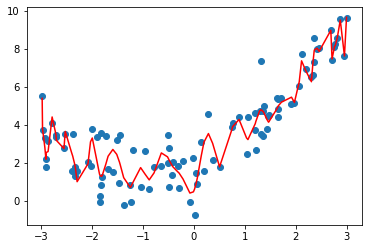

In [26]:
poly100_reg = PolynomialRegression(degree=100)
poly100_reg.fit(X,y)
y100_predict = poly100_reg.predict(X)
print(mean_squared_error(y,y100_predict))

plt.scatter(x,y)
plt.plot(np.sort(x),y100_predict[np.argsort(x)],color='r')

### 事实上，绘制的图像并不是真正拟合的曲线，曲线只是原有的y的预测值连接出来的结果
### 不过有很多地方没有数据点，所以连接结果与原来的曲线不同

(-3.0, 3.0, -1.0, 10.0)

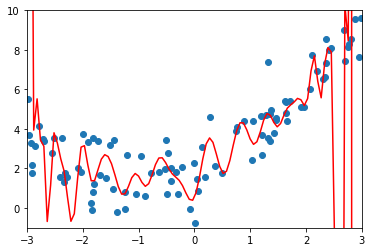

In [27]:
## 尝试真正还原原来的曲线：此时的X_plot在-3到3之间均匀取值，所以不会出现两个点的距离过大的情况
X_plot = np.linspace(-3,3,100).reshape(100,1)
y_plot = poly100_reg.predict(X_plot)
plt.scatter(x,y)
plt.plot(X_plot[:,0],y_plot,color='r')
plt.axis([-3,3,-1,10])  ##定义轴

## 当degree=100时的真正的多项式回归拟合的结果，degree越高拟合的结果越好
## 我们总能找到一根曲线，使得样本点全部落在这根曲线上，使得误差为0，这使得degree的结果一定很高


# 为什么要训练集和测试集

#### 模型的泛化能力：所谓的泛化能力，就是根据训练集得到的模型，衡量测试集对模型的拟合能力。

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [29]:
## 线性回归
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_predict = lin_reg.predict(X_test)
mean_squared_error(y_test, y_predict)  ##测试模型的泛化能力

2.219996526939657

In [30]:
## 多项式回归:显然多项式回归的泛化能力比线性回归好 
poly2_reg = PolynomialRegression(degree=2)
poly2_reg.fit(X_train, y_train)
y2_predict = poly2_reg.predict(X_test)
mean_squared_error(y_test, y2_predict) 

0.8035641056297901

In [31]:
## 当degree=100时，虽然训练集的拟合更好了，但是面对新的数据时，结果极差
poly2_reg = PolynomialRegression(degree=100)
poly2_reg.fit(X_train, y_train)
y2_predict = poly2_reg.predict(X_test)
mean_squared_error(y_test, y2_predict) 

248433465449.4833

#### 欠拟合underfitting ：算法所训练的模型不能完整描述数据关系
#### 过拟合overfitting ：算法所训练的模型过多地表达了数据间的噪音
#### 我们需要寻找泛化能力最好的地方

# 学习曲线

#### 学习曲线：随着训练样本的逐渐增多，算法训练处的模型的表现能力

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train.shape

(75, 1)

In [33]:
train_score =[]  ##记录模型在训练集上，对应的预测误差
test_score = []
for i in range(1,76):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train[:i] ,y_train[:i])
    
    y_train_predict = lin_reg.predict(X_train[:i])
    train_score.append(mean_squared_error(y_train[:i],y_train_predict))
    
    y_test_predict = lin_reg.predict(X_test)
    test_score.append(mean_squared_error(y_test,y_test_predict))

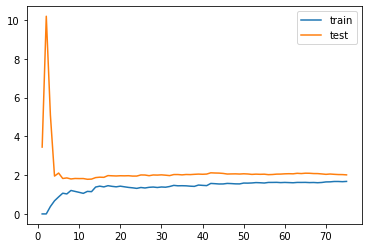

In [34]:
plt.plot([i for i in range(1,76)] , np.sqrt(train_score) , label='train')
plt.plot([i for i in range(1,76)] , np.sqrt(test_score) , label='test')
plt.legend()
plt.show()

#### 在训练集上，随着数据量的增加，误差逐渐升高，之后会趋于稳定
#### 在测试集上，随着数据量的增加，误差逐渐减小，之后会趋于稳定
#### 不过训练误差还是比测试误差小

In [35]:
from sklearn.metrics import mean_squared_error
def plot_learning_curve(algo, X_train, X_test, y_train, y_test):
    train_score =[]  ##记录模型在训练集上，对应的预测误差
    test_score = []
    for i in range(1,76):
        algo.fit(X_train[:i] ,y_train[:i])

        y_train_predict = algo.predict(X_train[:i])
        train_score.append(mean_squared_error(y_train[:i],y_train_predict))

        y_test_predict = algo.predict(X_test)
        test_score.append(mean_squared_error(y_test,y_test_predict))
        
    plt.plot([i for i in range(1,76)] , np.sqrt(train_score) , label='train')
    plt.plot([i for i in range(1,76)] , np.sqrt(test_score) , label='test')
    plt.axis([0,len(X_train)+1,0,4])  ## 坐标轴
    plt.legend()
    plt.xlabel('database size')
    plt.ylabel('MSE')
    plt.show()

### 1、欠拟合

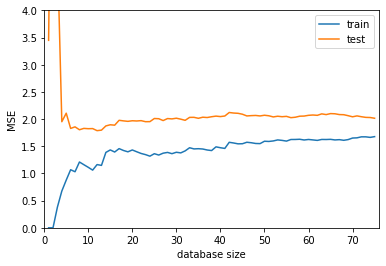

In [36]:
plot_learning_curve(LinearRegression(),X_train, X_test, y_train, y_test)

#### 对于训练集和测试集来说误差都比较大，可知模型选的就不对

### 2、最佳

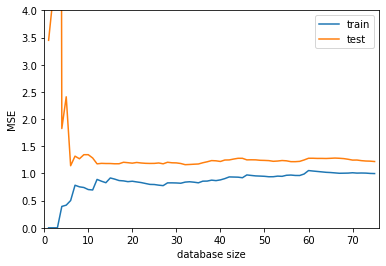

In [37]:
## 多项式回归
poly_reg = PolynomialRegression(degree=2)
plot_learning_curve(poly_reg,X_train, X_test, y_train, y_test)

### 3、过拟合

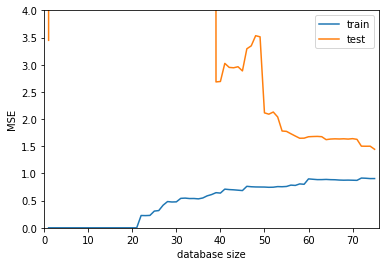

In [38]:
## 多项式回归
poly_reg = PolynomialRegression(degree=20)
plot_learning_curve(poly_reg,X_train, X_test, y_train, y_test)

#### 训练集上的误差与最佳情况基本一样，但是测试集的误差大，并且训练集与测试集误差较大

# 验证数据集与交叉验证

#### 通过测试集判断模型的好坏。通过调整超参数，来调整模型。

#### 我们想办法找到一组参数，使得在训练集上的模型，在测试集上效果最好。
#### 但由于测试集是已知的，我们相当于对测试集进行调参，也有可能产生或过拟合的情况，即模型对于测试集过拟合了

### 解决方案：
1、训练集：训练模型

2、验证集：作用是调参，需要使该模型对于验证集达到最优

3、测试集：（不参与模型的创建）作为衡量最终模型性能的数据集

即使这样划分，还会出现一个问题：随机？三个数据集都是随机的从原数据集中切分出来的。我们的模型去拟合验证集，一旦验证集中有极端的数据，就可能导致模型的不准确。

### 解决方案：交叉验证 Cross  Validation

![title](../img/21.png)

In [1]:
import numpy as np
from sklearn import datasets

In [2]:
digits = datasets.load_digits()   ##手写识别数据集
X = digits.data
y = digits.target
X.shape, y.shape

((1797, 64), (1797,))

#### 使用train_test_split

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4 ,random_state=666)
X_train.shape , X_test.shape

((1078, 64), (719, 64))

In [91]:
from sklearn.neighbors import KNeighborsClassifier

best_score, best_p, best_k = 0,0,0

for k in range(2,11):  
    for p in range(1,6):   ## p=1-5,当p=2是欧氏距离
        knn_clf = KNeighborsClassifier(weights='distance',n_neighbors=k,p=p)
        knn_clf.fit(X_train, y_train)
        score = knn_clf.score(X_test, y_test)
        
        if score > best_score:
            best_score, best_p, best_k = score, p, k

print('best_k = ',best_k)
print('best_p = ',best_p)
print('best_score = ',best_score)

best_k =  3
best_p =  4
best_score =  0.9860917941585535


#### 使用交叉验证 (五交叉验证：训练集分为5份)

In [107]:
## 该方法需要传进一个算法以及相应的X_train, y_train，
## 就会进行交叉验证的过程，并返回K个模型，每个模型的准确率
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf ,X_train, y_train ,cv=5)
## cv默认是5，默认把训练集分成5分进行交叉验证

array([0.99537037, 0.98148148, 0.97685185, 0.97674419, 0.97209302])

In [108]:
best_score, best_p, best_k = 0,0,0
for k in range(2,11):  
    for p in range(1,6):   ## p=1-5,当p=2是欧氏距离
        knn_clf = KNeighborsClassifier(weights='distance',n_neighbors=k,p=p)
        scores = cross_val_score(knn_clf ,X_train, y_train)  ##交叉验证
        score = np.mean(scores)   ## 求平均
        
        if score > best_score:
            best_score, best_p, best_k = score, p, k

print('best_k = ',best_k)
print('best_p = ',best_p)
print('best_score = ',best_score)

best_k =  2
best_p =  2
best_score =  0.9851507321274763


#### 结论一：使用train_test_split和交叉验证得出的 k 和p是不同的，通常我们会更相信交叉验证得出的参数
#### 结论二：使用交叉验证得出的最佳分数score比使用train_test_split得出的最佳分数小，因为交叉验证不会过拟合某一组的数据
### 注意：交叉验证的目的就是拿到最好的 k 和 p 而已， 我们需要用这组参数来进行测试

In [93]:
best_knn_clf = KNeighborsClassifier(weights='distance',n_neighbors=2,p=2)

best_knn_clf.fit(X_train, y_train)
best_knn_clf.score(X_test, y_test)

0.980528511821975

### 回顾网格搜索

In [102]:
from sklearn.model_selection import GridSearchCV   ## CV就是交叉验证的意思

param_grid = [
    {
        'weights':['distance'],
        'n_neighbors':[ i for i in range(2,11)],
        'p':[i for i in range(1,6)]
    }
]

grid_search = GridSearchCV(knn_clf, param_grid,verbose=1)
grid_search.fit(X_train,y_train)
## 我们需要对9*5=45组参数进行搜索，每组参数需要生成5个模型，来计算平均值，一共225次

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   26.9s finished


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'p': [1, 2, 3, 4, 5], 'weights': ['distance']}],
             verbose=1)

In [103]:
grid_search.best_score_  ## 最佳分数

0.9851507321274763

In [104]:
grid_search.best_params_   ##最佳参数

{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

In [106]:
best_knn_clf = grid_search.best_estimator_  ##获得最佳参数对应的最佳分类器
best_knn_clf.score(X_test,y_test)

##此结果与交叉验证得到的结果是完全一样的

0.980528511821975

#### k-folds交叉验证：把数据分成 k 份。缺点是每次训练K个模型，相当于整体性能慢了k倍
#### 极端情况下，把训练数据集一共有m个样本，就分成m份，称为留一法 LOO-CV（Leave-One-Out Cross Validation）（即每次使用m-1个样本进行训练，验证集只有1个样本）
#### 留一法完全不受随机的影响，最接近模型真正的性能，但是计算量巨大，论文中可能会用到

# 偏差方差权衡 Bias Variance Trade off

在机器学习领域，训练的时候出现的误差，应该怎样分类？

![title](../img/22.png)

### 模型误差 = 偏差Bias + 方差Variance + 不可避免的误差

1、导致偏差的主要原因：

欠拟合。对问题本身的假设不正确（如，非线性数据使用线性回归）。

2、方差

过拟合。数据的一点点扰动都会较大地影响模型。

通常原因是使用的模型太复杂。（如，高阶多项式回归）会导致泛化能力差

3、另外，有一些算法天生就是高方差的算法（如KNN对数据特别敏感、决策树）

通常，非参数学习的算法都是高方差算法，因为不对数据进行任何假设，对训练数据的依赖程度很高。


有一些算法天生是高偏差算法（如线性回归）

参数学习通常都是高偏差算法，因为对数据具有极强的假设，而现实中的数据可能没有关系

4、大多数算法具有相应的参数，可以调整偏差和方差。

KNN算法中对k的调整，就是调整偏差和方差的错误。k越小模型越复杂，方差越大，偏差越小。

线性回归中使用多项式回归，就可以调整多项式回归的degree参数，从而改变线性回归的偏差和方差。degree越小，模型越简单，偏差越大，方差越小。


### 偏差和方差通常是矛盾的。降低偏差就会提高方差。

### 在算法层面上，机器学习的主要挑战大多来自于方差！

#### 解决高方差问题（过拟合问题）的通常手段：
#### 1、降低模型复杂度  2、减少数据维度；降噪（PCA）  3、增加样本数  4、使用验证集  5、模型正则化

# 模型正则化 Regularization

#### 模型正则化：限制参数的大小，不让参数过大

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
###实例化Pipeline ，创建管道
def PolynomialRegression(degree):
    return Pipeline([                        
        ('poly', PolynomialFeatures(degree=degree)),  ##第一步：多项式特征
        ('std_scaler', StandardScaler()),           ##第二步：数值均一化
        ('lin_reg', lin_reg)             ##第三步：线性回归
    ])
        
from sklearn.metrics import mean_squared_error
poly100_reg = PolynomialRegression(degree=100)
poly100_reg.fit(X,y)
y100_predict = poly100_reg.predict(X)
mean_squared_error(y,y100_predict)

0.6779091288305205

(-3.0, 3.0, -1.0, 10.0)

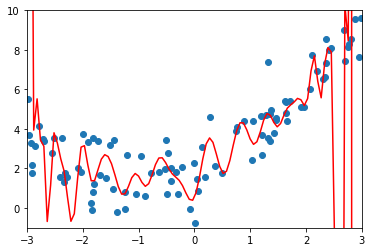

In [11]:
## 尝试真正还原原来的曲线：此时的X_plot在-3到3之间均匀取值，所以不会出现两个点的距离过大的情况
X_plot = np.linspace(-3,3,100).reshape(100,1)
y_plot = poly100_reg.predict(X_plot)
plt.scatter(x,y)
plt.plot(X_plot[:,0],y_plot,color='r')
plt.axis([-3,3,-1,10])  ##定义轴

## 当degree=100时的真正的多项式回归拟合的结果，degree越高拟合的结果越好
## 我们总能找到一根曲线，使得样本点全部落在这根曲线上，使得误差为0，这使得degree的结果一定很高


In [12]:
lin_reg.coef_  ## 查看系数，可以发现前面的系数值非常大，这就是过拟合的效果

array([ 3.60540632e+12,  1.14890238e+01,  1.74628909e+02, -2.55666858e+02,
       -1.73198403e+04, -1.74489227e+04,  7.93286223e+05,  8.77909591e+05,
       -2.09450354e+07, -1.54137984e+07,  3.57558127e+08,  1.21400074e+08,
       -4.20766952e+09, -1.41219127e+08,  3.54207872e+10, -5.88618855e+09,
       -2.17668326e+11,  5.99649826e+10,  9.83517509e+11, -3.11228340e+11,
       -3.24662807e+12,  1.00036461e+12,  7.62651643e+12, -2.00749960e+12,
       -1.19116462e+13,  2.19334659e+12,  1.00224340e+13, -3.51303025e+11,
        5.10413050e+11, -1.92030133e+12, -8.54305053e+12,  1.14277564e+12,
        1.48778195e+12,  1.42901234e+12,  8.32334818e+12, -9.11365694e+11,
       -1.20475866e+12, -7.51588708e+11, -6.87034620e+12, -7.48077976e+11,
       -2.74049066e+12,  1.11318103e+12,  5.29730093e+12,  7.41786787e+11,
        5.34312028e+12,  1.92639591e+11, -2.77214544e+11,  1.20009633e+11,
       -4.58962933e+12, -2.02566844e+12, -4.89886372e+12, -2.47022853e+11,
       -5.31084929e+11,  

#### 模型正则化：目标是使得损失函数值尽可能小


![title](../img/23.png)

### 上面的模型正则化的式子通常称为 ‘岭回归’ Ridge Regression ,这只是一种模型正则化的方式。
#### 注意：1、模型正则化的时候，目标函数不需要加θ_0 。
#### 2、最后一项的1/2的作用是在求导的时候可以约掉。
#### 3、α是一个超参数，作用是表示最后一项θ_i占整个损失函数的比重。

In [31]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
x = np.random.uniform(-3.0,3.0,size=100)   #100个数据，-3到3之间随机取值
X = x.reshape(-1,1)   ## X有100个样本，每个样本有1个特征
y = 0.5 * x + 3 + np.random.normal(0,1,size=100)

In [38]:
def PolynomialRegression(degree):
    return Pipeline([                        
        ('poly', PolynomialFeatures(degree=degree)),  ##第一步：多项式特征
        ('std_scaler', StandardScaler()),           ##第二步：数值均一化
        ('lin_reg', LinearRegression())             ##第三步：线性回归
    ])

In [39]:
from sklearn.model_selection import train_test_split
np.random.seed(666)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
## 使用多项式回归的方式进行样本的学习
poly_reg = PolynomialRegression(degree=20)
poly_reg.fit(X_train,y_train)
y_poly_predict = poly_reg.predict(X_test)
mean_squared_error(y_test,y_poly_predict)

167.94010862165914

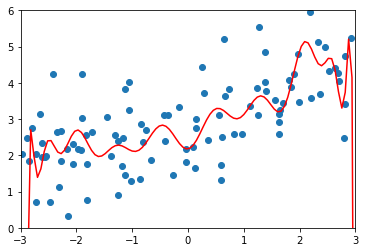

In [42]:
## 包装画图代码 
## 传入的参数model就是训练好的模型

def plot_model(model):
    X_plot = np.linspace(-3,3,100).reshape(100,1)
    y_plot = model.predict(X_plot)
    plt.scatter(x,y)
    plt.plot(X_plot[:,0],y_plot,color='r')
    plt.axis([-3,3,0,6])  ##定义轴
    plt.show()
    
plot_model(poly_reg)

#### 使用岭回归

In [43]:
from sklearn.linear_model import Ridge

def RidgeRegression(degree,alpha):
    return Pipeline([                        
        ('poly', PolynomialFeatures(degree=degree)),  ##第一步：多项式特征
        ('std_scaler', StandardScaler()),             ##第二步：数值均一化
        ('ridge_reg', Ridge(alpha=alpha))             ##第三步：岭回归
    ])

In [45]:
## 为了使系数系数θ小一些，可以把α的系数设置的小一些
ridge1_reg = RidgeRegression(20,0.0001)
ridge1_reg.fit(X_train,y_train)

y1_predict = ridge1_reg.predict(X_test)
mean_squared_error(y_test,y1_predict)
##这个结果比之前的167好太多，因为模型正则化使得模型的泛华能力大大提高

1.3233492754169978

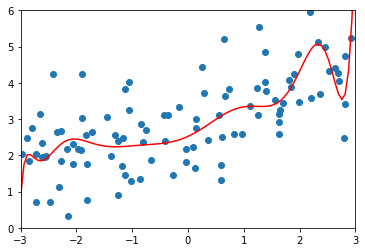

In [46]:
plot_model(ridge1_reg)

In [55]:
## 增大α的值，注意：如果α非常大的时候，模型就是一条直线
ridge2_reg = RidgeRegression(20,100)
ridge2_reg.fit(X_train,y_train)

y2_predict = ridge2_reg.predict(X_test)
mean_squared_error(y_test,y2_predict)

1.3196456113086197

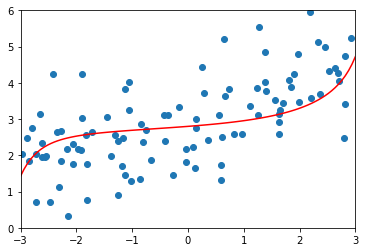

In [56]:
plot_model(ridge2_reg)

# 模型正则化的另一种方式：LASSO回归

![title](../img/24.png)

#### 对于岭回归，因为后面的一项是平方和，所以需要α很小来调节
#### 对于Lasso回归，因为后面一项是绝对值和，所以这里的α取值会比岭回归中的α大

In [57]:
from sklearn.linear_model import Lasso

def LassoRegression(degree,alpha):
    return Pipeline([                        
        ('poly', PolynomialFeatures(degree=degree)),  ##第一步：多项式特征
        ('std_scaler', StandardScaler()),           ##第二步：数值均一化
        ('lasso_reg', Lasso(alpha=alpha))             ##第三步：Lasso回归
    ])

In [58]:
lasso1_reg = LassoRegression(20,0.01)
lasso1_reg.fit(X_train,y_train)

y1_predict = lasso1_reg.predict(X_test)
mean_squared_error(y_test,y1_predict)

1.1496080843259966

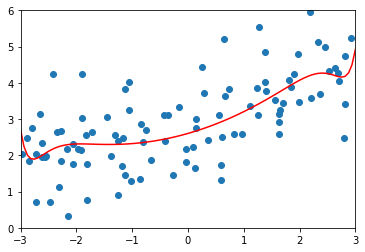

In [59]:
plot_model(lasso1_reg)

In [62]:
## 增大α
lasso2_reg = LassoRegression(20,0.1)
lasso2_reg.fit(X_train,y_train)

y2_predict = lasso2_reg.predict(X_test)
mean_squared_error(y_test,y2_predict)

1.1213911351818648

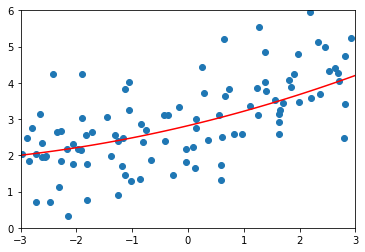

In [63]:
plot_model(lasso2_reg)

#### 岭回归中的模型更倾向于是曲线，总是保持弯曲的形状
#### Lasso回归中的模型基本成直线的形状
#### 原因：岭回归会使系数θ变成很小的值 ， 但是lasso会使系数θ都为0
### lasso 趋向于使得一部分θ的值变为0，就代表说lasso认为θ为0对应的特征是没有用的，所以可以做特征选择用。

#### lasso回归可能会把一些原本有用的特征筛选为无用的特征,从计算的准确度来讲，岭回归计算的更为准确。

# L1正则、L2正则和弹性网络

![title](../img/25.png)

#### 第一列衡量：正则化
#### 第二列衡量：回归结果的好坏
#### 第三列衡量：两点之间距离的大小

![title](../img/26.png)

## 弹性网：包含L1和L2正则项，并且引入新的超参数r

![title](../img/27.png)

#### 什么时候使用弹性网？
#### 之前我们讲过，岭回归的计算比lasso回归精准，但是在特征数量特别多的情况下，由于岭回归不具有特征选择的功能，所以计算量会特别大，此时优先选择弹性网。因为弹性网结合了两者的优势。

# 逻辑回归 ：是分类问题

#### 将样本的特征和样本发生的概率联系起来，概率是一个数
#### 逻辑回归既可以看做回归算法，也可以看做分类算法
#### 通常作为分类算法用，只解决二分类问题

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(t):
    return 1/(1+np.exp(-t))
## 值域在0-1之

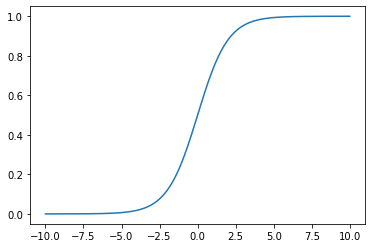

In [4]:
x = np.linspace(-10,10,500)
y = sigmoid(x)
plt.plot(x,y)

![title](../img/28.png)

![title](../img/29.png)

![title](../img/30.png)

![title](../img/31.png)

### Xb是特征矩阵前面加上一列1之后形成的矩阵

![title](../img/32.png)

![title](../img/33.png)

![title](../img/34.png)

![title](../img/35.png)

# 实现逻辑回归算法

In [31]:
import numpy as np

class LogisticRegression:

    def __init__(self):
        self.coef_ = None   ##系数  对应θ1-θn
        self.interception_ = None   ##截距 ,对应θ0
        self._theta = None  ##私有变量，前面有_
        
    def _sigmoid(self,t):   ##私有函数
        return 1/(1+np.exp(-t))
    
    ## 使用批量梯度下降法 ， 根据训练数据集X_train\y_train,使用批量梯度下降法来训练模型
    def fit(self , X_train , y_train,eta=0.01,n_iters=1e4):
        
        ##损失函数
        def J(theta,X_b,y): 
            y_hat = self._sigmoid(X_b.dot(theta))
            try:
                return - np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat)) / len(y)
            except:
                return float('inf') ##防止溢出情况，防止学习率过大，检测到异常，返回损失函数的最大值

        ##损失函数求导
        def dJ(theta , X_b , y):
            return X_b.T.dot(self._sigmoid(X_b.dot(theta)) - y) / len(X_b)

        ## 梯度下降 (代码与线性回归一样，完全不需要改动)
        def gradient_descent(X_b , y ,initial_theta , eta, n_iters = 1e4,epsilon=1e-8):
            theta = initial_theta
            i_iter = 0       ### n_iters是迭代次数

            while i_iter < n_iters:
                gradient = dJ(theta,X_b , y)
                last_theta = theta  ##保存上一次的theta
                theta = theta - eta * gradient    ##更新theta

                if (abs(J(theta,X_b , y) - J(last_theta,X_b , y)) < epsilon):
                    break
                i_iter += 1
            return theta
        
        X_b = np.hstack([np.ones((len(X_train),1)), X_train])
        initial_theta = np.zeros(X_b.shape[1])
        self._theta = gradient_descent(X_b , y_train ,initial_theta , eta, n_iters)
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self  
    
    def predict_proba( self,X_predict):
        ##给定带预测数据集X_predict,返回表示X_predict的结果概率向量#
        X_b = np.hstack([np.ones( (len(X_predict),1 )),X_predict])
        return self._sigmoid(X_b.dot(self._theta))
    
    def predict( self,X_predict):
        ##给定带预测数据集X_predict,返回表示X_predict的结果结果向量#
        proba = self.predict_proba(X_predict)
        return np.array(proba >=0.5 , dtype='int')  # 返回的数组元素原本是布尔值（T和F），强制转换成int值（0和1）
    
    def score(self,X_test,y_test):
        ##根据测试数据集X_test和y_test,确定模型的准确度##
        y_predict = self.predict(X_test)
        return sum(y_test == y_predict) / len(y_test)

In [21]:
from sklearn import datasets
iris = datasets.load_iris()

In [22]:
X = iris.data
y = iris.target

X = X[y<2 , :2]  ##取y=0和y=1的行，只取前两个特征
y = y[y<2]
X.shape,y.shape

((100, 2), (100,))

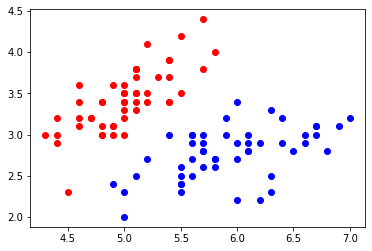

In [23]:
plt.scatter(X[y==0,0],X[y==0,1],color='red') 
plt.scatter(X[y==1,0],X[y==1,1],color='blue') 

#### 使用逻辑回归

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=666)

In [34]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

In [35]:
log_reg.score(X_test,y_test)

1.0

In [36]:
log_reg.predict_proba(X_test)   ## 数据大于0.5，就分类为1。小于0.5，就分类为0

array([0.93292947, 0.98717455, 0.15541379, 0.01786837, 0.03909442,
       0.01972689, 0.05214631, 0.99683149, 0.98092348, 0.75469962,
       0.0473811 , 0.00362352, 0.27122595, 0.03909442, 0.84902103,
       0.80627393, 0.83574223, 0.33477608, 0.06921637, 0.21582553,
       0.0240109 , 0.1836441 , 0.98092348, 0.98947619, 0.08342411])

In [37]:
y_test

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0])

In [39]:
log_reg.predict(X_test)  

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0])

In [41]:
log_reg.coef_

array([ 3.01749692, -5.03046934])

In [42]:
log_reg.intercept_

-0.6827383698993109

# 决策边界

![title](../img/36.png)

In [45]:
def x2(x1):
    return (-log_reg.coef_[0]*x1 - log_reg.intercept_)/log_reg.coef_[1]

In [46]:
x1_plot = np.linspace(4,8,1000)
x2_plot = x2(x1_plot)

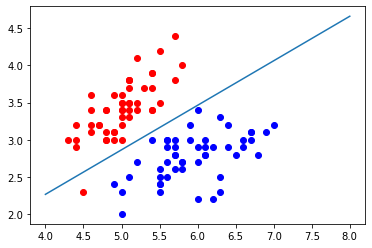

In [47]:
plt.scatter(X[y==0,0],X[y==0,1],color='red') 
plt.scatter(X[y==1,0],X[y==1,1],color='blue') 
plt.plot(x1_plot,x2_plot)

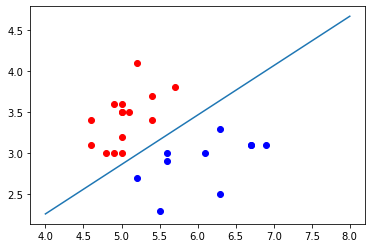

In [48]:
## 测试结果准确率是1，我们只对测试集进行展示
plt.scatter(X_test[y_test==0,0],X_test[y_test==0,1],color='red') 
plt.scatter(X_test[y_test==1,0],X_test[y_test==1,1],color='blue') 
plt.plot(x1_plot,x2_plot)

### 不规则的决策边界的绘制方法

In [52]:
## 绘制决策边界
def plot_decison_boundary(model,axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])

    plt.contourf(x0, x1, zz, cmap=custom_cmap)

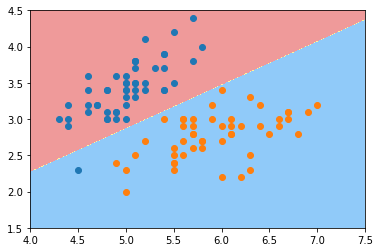

In [54]:
plot_decison_boundary(log_reg,axis=[4,7.5,1.5,4.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

### KNN 的决策边界 （无表达式）

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf =  KNeighborsClassifier()
knn_clf.fit(X_train ,y_train)
knn_clf.score(X_test, y_test)

1.0

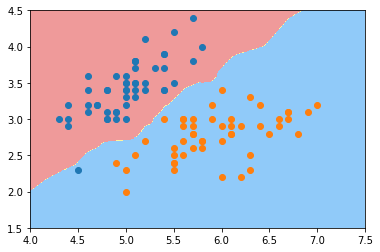

In [59]:
plot_decison_boundary(knn_clf,axis=[4,7.5,1.5,4.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [65]:
#### 三个类别
knn_clf_all = KNeighborsClassifier()
knn_clf_all.fit(iris.data[:,:2] , iris.target)
## 此时k的默认值为5，k越小模型越复杂

KNeighborsClassifier()

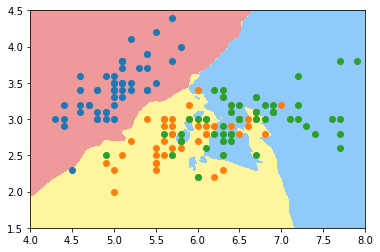

In [66]:
plot_decison_boundary(knn_clf_all,axis=[4,8,1.5,4.5])
plt.scatter(iris.data[iris.target==0,0],iris.data[iris.target==0,1])
plt.scatter(iris.data[iris.target==1,0],iris.data[iris.target==1,1])
plt.scatter(iris.data[iris.target==2,0],iris.data[iris.target==2,1])
plt.show()

#### 上图中的黄色部分中还存在蓝色的，显然就是过拟合的表现

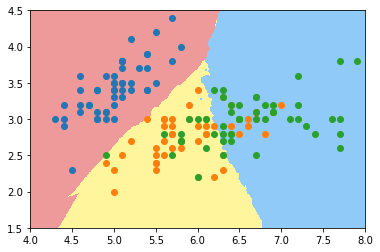

In [69]:
## 增大k
knn_clf_all = KNeighborsClassifier(n_neighbors=50)
knn_clf_all.fit(iris.data[:,:2] , iris.target)

plot_decison_boundary(knn_clf_all,axis=[4,8,1.5,4.5])
plt.scatter(iris.data[iris.target==0,0],iris.data[iris.target==0,1])
plt.scatter(iris.data[iris.target==1,0],iris.data[iris.target==1,1])
plt.scatter(iris.data[iris.target==2,0],iris.data[iris.target==2,1])
plt.show()

# 在逻辑回归中使用多项式特征

#### 逻辑回归是在特征平面中，找到一个直线，用直线把样本分割为两类。
#### 但是直线分类太简单了，我们需要找到非直线的决策边界
#### 在逻辑归回中引入多项式项，就可以得到非线性的数据进行分类，得到曲线的决策边界

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
### 随机生成样本数据
np.random.seed(666)
X = np.random.normal(0,1,size=(200,2)) ##均值为0.标准差为1
y = np.array(X[:,0]**2 + X[:,1]**2 <1.5 , dtype='int') ##把布尔型强制转换为int型

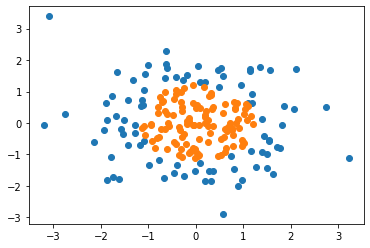

In [74]:
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

### 使用逻辑回归

In [75]:
log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)   # 分类准确度只有60%

0.605

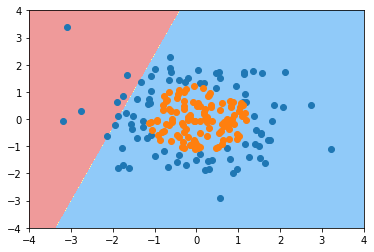

In [76]:
plot_decison_boundary(log_reg,axis=[-4,4,-4,4])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [80]:
## 添加多项式项，使用管道
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
def PolynomialLogisticRegression(degree):
    return Pipeline([                        
        ('poly', PolynomialFeatures(degree=degree)),##第一步：多项式特征
        ('std_scaler', StandardScaler()),           ##第二步：数值均一化
        ('log_reg', LogisticRegression())           ##第三步：逻辑回归（我们自己实现的逻辑归回）
    ])

In [81]:
poly_log_reg = PolynomialLogisticRegression(degree=2)  ##添加2次幂的特征
poly_log_reg.fit(X,y)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()),
                ('log_reg',
                 <__main__.LogisticRegression object at 0x000001BEAFDD5DF0>)])

In [83]:
poly_log_reg.score(X,y)

0.95

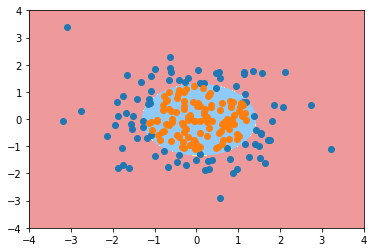

In [84]:
plot_decison_boundary(poly_log_reg,axis=[-4,4,-4,4])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [85]:
## 增大degree
poly_log_reg2 = PolynomialLogisticRegression(degree=20)  
poly_log_reg2.fit(X,y)
poly_log_reg2.score(X,y)

0.955

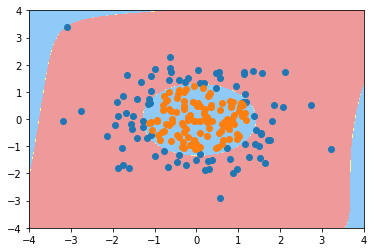

In [86]:
plot_decison_boundary(poly_log_reg2,axis=[-4,4,-4,4])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

#### 出现了奇怪的外围边界，因为degree太大了，模型太复杂，导致了过拟合

#### 解决过拟合问题：模型正则化

# 逻辑回归中使用模型正则化，scikit-learn中的逻辑回归

#### scikit-learn中的逻辑回归都建议使用模型正则化

In [91]:
# 生成样本
np.random.seed(666)
X = np.random.normal(0,1,size=(200,2)) 
y = np.array(X[:,0]**2 + X[:,1] <1.5 , dtype = 'int')

# 添加噪音 ，随机挑选20个点，强制分类结果为1
for _ in range(20):
    y[np.random.randint(200)] = 1

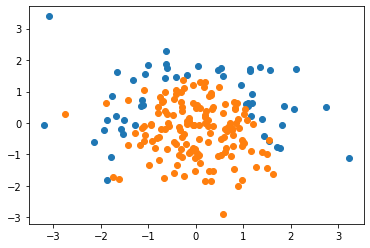

In [92]:
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

### 使用scikit-learn中的逻辑回归

In [94]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [95]:
log_reg.score(X_train, y_train)  ## 在训练集上的准确率

0.7933333333333333

In [96]:
log_reg.score(X_test, y_test) # 在测试集上的准确率

0.86

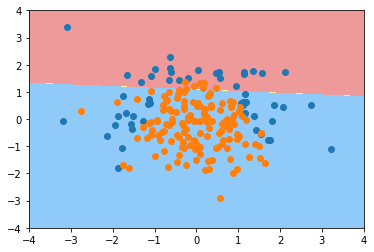

In [98]:
plot_decison_boundary(log_reg,axis=[-4,4,-4,4])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

### 多项式的逻辑回归

![title](../img/37.png)

In [107]:
poly_log_reg = PolynomialLogisticRegression(degree=2)
poly_log_reg.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()),
                ('log_reg', LogisticRegression())])

In [108]:
poly_log_reg.score(X_train, y_train)

0.9066666666666666

In [109]:
poly_log_reg.score(X_test, y_test)

0.94

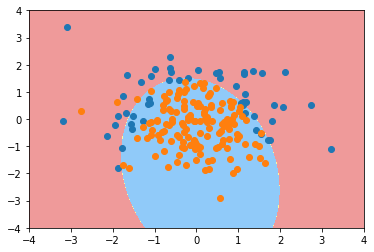

In [110]:
## 绘制决策边界
plot_decison_boundary(poly_log_reg,axis=[-4,4,-4,4])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

0.94
0.92


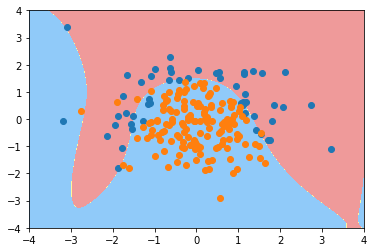

In [112]:
## 增大degree的值，会发生过拟合
poly_log_reg = PolynomialLogisticRegression(degree=20)
poly_log_reg.fit(X_train, y_train)

print(poly_log_reg.score(X_train, y_train))
print(poly_log_reg.score(X_test, y_test))

plot_decison_boundary(poly_log_reg,axis=[-4,4,-4,4])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [116]:
## 改进：进行模型正则化
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

## 逻辑回归默认使用L2正则项，C是损失函数前面的系数
def PolynomialLogisticRegression(degree,C):
    return Pipeline([                        
        ('poly', PolynomialFeatures(degree=degree)),##第一步：多项式特征
        ('std_scaler', StandardScaler()),           ##第二步：数值均一化
        ('log_reg', LogisticRegression(C=C))        ##第三步：逻辑回归
    ])

0.84
0.92


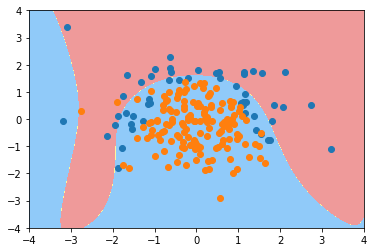

In [117]:
poly_log_reg3 = PolynomialLogisticRegression(degree=20 , C=0.1)
## C=0.1 就是让模型正则化的项起更大的作用，损失函数起的作用小
poly_log_reg3.fit(X_train, y_train)

print(poly_log_reg3.score(X_train, y_train))
print(poly_log_reg3.score(X_test, y_test))

plot_decison_boundary(poly_log_reg3,axis=[-4,4,-4,4])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [130]:
## 使用L1正则项 
def PolynomialLogisticRegression(degree,C,penalty='l2',solver='liblinear'):
    return Pipeline([                        
        ('poly', PolynomialFeatures(degree=degree)),##第一步：多项式特征
        ('std_scaler', StandardScaler()),           ##第二步：数值均一化
        ('log_reg', LogisticRegression(C=C,penalty=penalty,solver=solver))    ##第三步：逻辑回归
    ])

0.8266666666666667
0.9


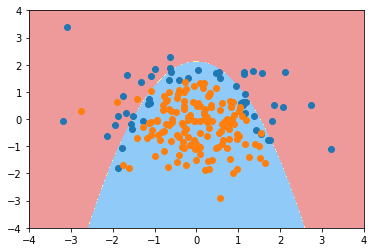

In [131]:
poly_log_reg4 = PolynomialLogisticRegression(degree=20 ,C=0.1,penalty='l1',solver='liblinear')
poly_log_reg4.fit(X_train, y_train)

print(poly_log_reg4.score(X_train, y_train))
print(poly_log_reg4.score(X_test, y_test))

plot_decison_boundary(poly_log_reg4,axis=[-4,4,-4,4])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

### 对于实际模型，我们不知道degree、C取值多少合适，不知道使用L1/L2正则项，这些参数都是超参数，我们需要使用网格搜索的方式来寻找最合适的超参数。

#### 上面所讲，逻辑回归只能解决二分类问题，但是我们可以使用一些方法使得逻辑归回可以解决多分类问题？OvR 和OvO

# OvR（One vs Rest）  OvO（One vs One）

#### OvR : n个类别就进行n次二分类的任务，新来的样本点对每一个二分类任务都计算出对应的概率，选择分类得分最高的类别。

![title](../img/38.png)

#### OvO : 每次只挑选出两个类别，进行二分类。对于新来的样本点，使用6个分类器都预测样本点属于哪个类别，然后再进行投票，哪个票数多，就判定新样本属于该类别。

![title](../img/39.png)

#### OvO 消耗的时间更多，但分类结果更准确。

In [147]:
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [163]:
# 完成多分类任务 , 分类方式是ovr，计算方式是liblinear
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='ovr',solver='liblinear')  
log_reg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [157]:
log_reg.score(X_test,y_test)

0.6578947368421053

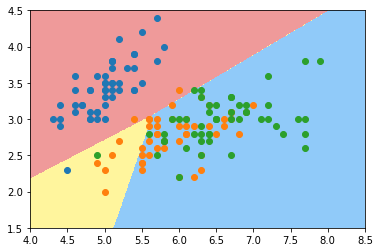

In [158]:
plot_decison_boundary(log_reg,axis=[4,8.5,1.5,4.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==2,0],X[y==2,1])

In [160]:
## 使用ovo方式 ， 计算方式是newton-cg
log_reg2 = LogisticRegression(multi_class='multinomial',solver='newton-cg')  
log_reg2.fit(X_train, y_train)
log_reg2.score(X_test,y_test)

0.7894736842105263

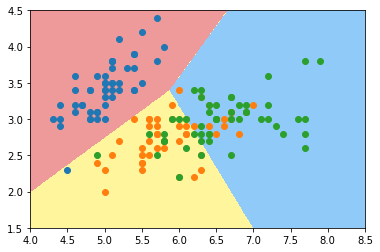

In [162]:
plot_decison_boundary(log_reg2,axis=[4,8.5,1.5,4.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==2,0],X[y==2,1])

### 使用所有的数据

In [165]:
X = iris.data
y = iris.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [171]:
#### 使用  OVR  的方式
log_reg = LogisticRegression(multi_class='ovr',solver='liblinear')  
log_reg.fit(X_train, y_train)
log_reg.score(X_test,y_test)

0.9473684210526315

In [172]:
#### 使用  OVO  的方式 ：时间长，准确率高
#### 之前的版本默认方式是OVR，我的版本默认OVO方式
log_reg2 = LogisticRegression(multi_class='multinomial',solver='newton-cg')  
log_reg2.fit(X_train, y_train)
log_reg2.score(X_test,y_test)

1.0

#### sklearn中的OVR，这个和上面的LogisticRegression调用参数使用OVR的结果一样

In [174]:
#### sklearn中的OVR
from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(log_reg)
ovr.fit(X_train, y_train)
ovr.score(X_test,y_test)

0.9473684210526315

#### sklearn中的OVO，这个和上面的LogisticRegression调用参数使用OVO的结果一样

In [175]:
from sklearn.multiclass import OneVsOneClassifier
ovr = OneVsOneClassifier(log_reg)
ovr.fit(X_train, y_train)
ovr.score(X_test,y_test)

1.0

# 分类算法的评价，准确度的缺陷和混淆矩阵

#### 对于回归问题，评价指标有MSE,MAE,RMSE,R Square
#### 但是对于分类问题，之前我们只讲过一种评价指标就是分类准确度

#### 分类准确度评价分类问题的缺点？？？
对于极度偏斜（Skewed Data）的数据集，只是用分类准确度是远远不够的。

### 混淆矩阵（confusion matrix）
对于二分类问题是一个2*2的矩阵。每一行是代表真实值，每一列代表预测值

![title](../img/40.png)

# 精准率和召回率

![title](../img/41.png)

#### 精准率：预测数据为1，相应的额预测对的比率是多少
使用场景：比如在医疗中，我们将1作为真正的患病，表示预测癌症的成功率

我们预测100个人有癌症，实际预测对的概率

![title](../img/42.png)

#### 召回率：关注的事件发生了，并且被我们正确预测到的概率
比如：真实的癌症患者有10个，在这10个当中我们能成功预测到了8个

实际有100个癌症病人，我们能成功的预测到的概率

# 实现混淆矩阵、精准率和召回率

In [182]:
import numpy as np
from sklearn import datasets

In [183]:
digits = datasets.load_digits()   ## 手写识别数据集
X = digits.data
y = digits.target.copy() #拷贝一下，后面我们修改y的时候就不会对digits.target产生影响了

In [184]:
### 手动让这个数据集产生较大的偏斜 , 变成一个二分类问题
y[digits.target==9] = 1
y[digits.target!=9] = 0

In [191]:
## 使用逻辑回归算法
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=100)
log_reg.fit(X_train, y_train)
log_reg.score(X_test,y_test)

## 默认的max_iter的最小值为100，是求取损失函数最小值的最大迭代次数
## 出现下面的问题可以忽略，也可以增大max_iter的值，同时也会增大准确率

D:\zzj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9755555555555555

In [192]:
y_log_predict = log_reg.predict(X_test)

In [193]:
def TN(y_true , y_predict):
    return np.sum((y_true ==0) & (y_predict == 0))
def FP(y_true , y_predict):
    return np.sum((y_true ==0) & (y_predict == 1))
def FN(y_true , y_predict):
    return np.sum((y_true ==1) & (y_predict == 0))
def TP(y_true , y_predict):
    return np.sum((y_true ==1) & (y_predict == 1))

In [195]:
print(TN(y_test , y_log_predict))
print(FP(y_test , y_log_predict))
print(FN(y_test , y_log_predict))
print(TP(y_test , y_log_predict))

403
2
9
36


In [198]:
## 混淆矩阵
def confusion_matrix(y_true , y_predict):
    return np.array([
        [TN(y_test , y_predict) , FP(y_test , y_predict)],
        [FN(y_test , y_predict) , TP(y_test , y_predict)]
    ])

confusion_matrix(y_test , y_log_predict)

array([[403,   2],
       [  9,  36]])

In [200]:
## 精准率
def precison_score(y_true , y_predict):
    tp = TP(y_test , y_predict)
    fp = FP(y_test , y_predict)
    try:   
        return tp/(tp+fp)
    except:
        return 0.0
    
precison_score(y_test , y_log_predict)

0.9473684210526315

In [202]:
## 召回率
def recall_score(y_true , y_predict):
    tp = TP(y_test , y_predict)
    fn = FN(y_test , y_predict)
    try:   
        return tp/(tp+fn)
    except:
        return 0.0
    
recall_score(y_test , y_log_predict)

0.8

### scikit-learn 中的混淆矩阵、精准率和召回率

In [203]:
## 混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test , y_log_predict)

array([[403,   2],
       [  9,  36]], dtype=int64)

In [204]:
## 精准率
from sklearn.metrics import precision_score
precison_score(y_test , y_log_predict)

0.9473684210526315

In [205]:
## 召回率
from sklearn.metrics import recall_score
recall_score(y_test , y_log_predict)

0.8

# 解读精准率和召回率

#### 对于不同的问题，我们会关注不同的指标。
在对于股票的预测中，更看重精准率。

在医疗领域，病人的诊断，更看重召回率。
#### F1 Score 同时兼顾精准率和召回率
#### F1 Score是precison 和 recall 的调和平均值。 因为只要precison 和 recall 中有一个非常小，都会很大程度的拉低调和平均值。

![title](../img/43.png)

In [211]:
def f1_score(precision , recall):
    try:
        return (2*precision*recall) / (precision+recall)
    except:
        return 0.0

In [212]:
precision = 0.5
recall = 0.5
f1_score(precision , recall)

0.5

In [213]:
precision = 0.1
recall = 0.9
f1_score(precision , recall)

0.18000000000000002

In [215]:
from sklearn.metrics import f1_score
f1_score(y_test,y_log_predict)

0.8674698795180723

# Precison-Recall 的平衡

#### 精准率和召回率是矛盾的，一个提高另一个就会下降

In [216]:
log_reg.decision_function(X_test) ##得到逻辑归回中每个样本对应的预测值
##预测值为正的话，预测结果就是1，预测值为负的话，预测结果为0

array([-21.40036141, -32.89622343, -16.4121082 , -79.81951813,
       -48.03525356, -24.18475282, -44.60321901, -24.25056084,
        -1.14143903, -19.00267268, -65.82072657, -50.96796804,
       -30.92661033, -45.94710939, -37.36195655, -29.50584656,
       -36.931303  , -82.80162051, -37.62761763,  -9.88212917,
        -9.26464311, -85.24390095, -16.74866282, -45.34626797,
        -5.02560959, -48.2901304 , -11.66078109, -37.36885943,
       -25.08319182, -13.59971533, -16.59924501, -28.78517125,
       -34.36429303, -28.52399115,  -8.10897689,  -4.59373679,
       -21.96057052, -21.87534818, -31.19718732, -23.35454569,
       -26.90433135, -62.23413325, -37.69038531, -66.36606158,
       -20.10033993, -16.69363201, -18.16401007, -21.55111856,
       -28.9660692 , -19.6160151 ,   2.40511883,   7.7325848 ,
       -34.87791962, -42.70806195, -25.62718842, -34.74666545,
        -7.59825904, -49.50790452, -51.52639488,  19.65822279,
       -10.08740684, -32.00141023, -11.49913845,  -1.41

In [217]:
log_reg.decision_function(X_test)[:10]

array([-21.40036141, -32.89622343, -16.4121082 , -79.81951813,
       -48.03525356, -24.18475282, -44.60321901, -24.25056084,
        -1.14143903, -19.00267268])

In [218]:
log_reg.predict(X_test)[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

![title](../img/44.png)

### 逻辑回归中的阈值是0，我们可以调整阈值，基于不同的阈值进行分类

In [226]:
decision_scores = log_reg.decision_function(X_test)
np.min(decision_scores),np.max(decision_scores) ##查看最大值和最小值

(-85.72197563981476, 19.890494217065623)

In [227]:
### 调整阈值：希望大于等于5的样本分类为1，小于5的样本分类为0
y_predict_2 = np.array(decision_scores >= 5 , dtype='int')

In [228]:
confusion_matrix(y_test,y_predict_2)

array([[404,   1],
       [ 21,  24]], dtype=int64)

In [229]:
precision_score(y_test,y_predict_2)  ##虽然提高了精准率

0.96

In [230]:
recall_score(y_test,y_predict_2)    ##但是降低了召回率

0.5333333333333333

# Precison-Recall 曲线

In [232]:
import numpy as np
from sklearn import datasets
digits = datasets.load_digits()   ## 手写识别数据集
X = digits.data
y = digits.target.copy()

### 手动让这个数据集产生较大的偏斜 , 变成一个二分类问题
y[digits.target==9] = 1
y[digits.target!=9] = 0

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

## 使用逻辑回归算法
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=100)
log_reg.fit(X_train, y_train)
log_reg.score(X_test,y_test)
## 默认的max_iter的最小值为100，是求取损失函数最小值的最大迭代次数
## 出现下面的问题可以忽略，也可以增大max_iter的值，同时也会增大准确率

D:\zzj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9755555555555555

In [236]:
decision_scores = log_reg.decision_function(X_test)  ##得到逻辑归回中每个样本对应的预测值

In [237]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precisions = []   ## 用来存储精准率
recalls = []
## 数组的起点是decision_scores的最小值，终点是decision_scores最大值，步长0.1
thresholds = np.arange( np.min(decision_scores),np.max(decision_scores) , 0.1)
for threshold in thresholds:
    y_predict = np.array(decision_scores >= threshold , dtype='int')
    precisions.append(precision_score(y_test,y_predict))
    recalls.append(recall_score(y_test,y_predict))

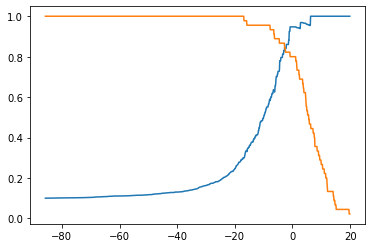

In [239]:
plt.plot(thresholds,precisions)  ##蓝色的曲线是精确率
plt.plot(thresholds,recalls)     ##橙色的曲线是召回率

### Precison-Recall 曲线

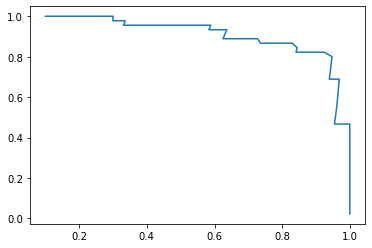

In [242]:
plt.plot(precisions,recalls)
## 在召回率急剧下降之前的点，可能就是精确率和召回率最好的平衡位置
## 在这个点之后的召回率急剧下降，而在这个点之前的召回率下降的幅度并不高

### scikit-leran 中的 Precison-Recall 曲线

In [243]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_test , decision_scores)

In [244]:
precisions.shape   ## precision_recall_curve会根据实际来取最合适的步长

(151,)

In [245]:
recalls.shape

(151,)

In [248]:
thresholds.shape   ## 比recalls少一个元素
## 最大的精准率是1，对应的召回率就是0，此时没有对应的threshold

(150,)

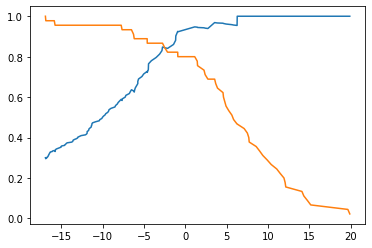

In [249]:
plt.plot(thresholds , precisions[:-1]) ## 去掉precisions的最后一个值
plt.plot(thresholds , recalls[:-1])

## 横轴代表不同的threshold，随着threshold的改变，precision 和 recall的变化趋势

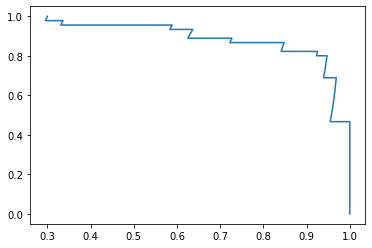

In [250]:
### 绘制PR曲线 ：反应了精确率和召回率的平衡，和变化的关系
plt.plot(precisions,recalls)
## 在召回率急剧下降之前的点，可能就是精确率和召回率最好的平衡位置

![title](../img/45.png)

#### 如果一个模型的PR曲线更靠外的话（更准确的说是PR曲线与两个轴闭合的面积越大），该模型就会更好。所以PR曲线也可以用来选择模型，选择超参数。

# ROC 曲线

#### ROC曲线描述 TPR（recall） 和 FPR 之间的关系

![title](../img/46.png)

In [252]:
def TPR(y_true , y_predict):
    tp = TP(y_test , y_predict)
    fn = FN(y_test , y_predict)
    try:   
        return tp/(tp+fn)
    except:
        return 0.0
    
def FPR(y_true , y_predict):
    fp = FP(y_test , y_predict)
    tn = TN(y_test , y_predict)
    try:   
        return fp/(fp+tn)
    except:
        return 0.0

In [255]:
fprs = []
tprs = []
thresholds = np.arange( np.min(decision_scores),np.max(decision_scores), 0.1)

for threshold in thresholds:
    y_predict = np.array( decision_scores >= threshold , dtype='int')
    fprs.append(FPR(y_test, y_predict))
    tprs.append(TPR(y_test, y_predict))

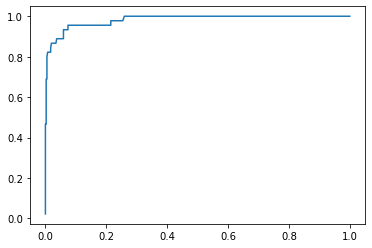

In [256]:
plt.plot(fprs,tprs)

### scikit-learn 中的 ROC

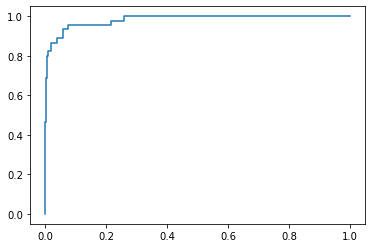

In [259]:
from sklearn.metrics import roc_curve
fprs,tprs,threshold = roc_curve(y_test,decision_scores)
plt.plot(fprs,tprs)

#### 对于ROC曲线，我们通常关注曲线下面的面积大小，面积越大表示模型的效果越好

In [260]:
## 计算面积
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,decision_scores)

## roc_auc对于有偏差的数据不太敏感

0.9823319615912208

# 多分类问题中的混淆矩阵

In [270]:
import numpy as np
from sklearn import datasets
digits = datasets.load_digits() 
X = digits.data
y = digits.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8,random_state=666)

## 使用逻辑回归算法
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='ovr',solver='liblinear') #使用OVR的方式
log_reg.fit(X_train, y_train)
log_reg.score(X_test,y_test)

0.93115438108484

In [271]:
y_predict = log_reg.predict(X_test)

In [272]:
from sklearn.metrics import precision_score
## precision_scoree默认解决二分类问题,average='binary'
precision_score(y_test,y_predict ,average='micro')

0.93115438108484

In [273]:
## 混淆矩阵:天然支持多分类问题
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_predict)
## 十分类问题就得到10*10的矩阵
## 第i行第j列的位置表示：真值为i，我们将它预测为j的样本数

array([[147,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0, 123,   1,   2,   0,   0,   0,   3,   4,  10],
       [  0,   0, 134,   1,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0, 138,   0,   5,   0,   1,   5,   0],
       [  2,   5,   0,   0, 139,   0,   0,   3,   0,   1],
       [  1,   3,   1,   0,   0, 146,   0,   0,   1,   0],
       [  0,   2,   0,   0,   0,   1, 131,   0,   2,   0],
       [  0,   0,   0,   1,   0,   0,   0, 132,   1,   2],
       [  1,   9,   2,   3,   2,   4,   0,   0, 115,   4],
       [  0,   1,   0,   5,   0,   3,   0,   2,   2, 134]], dtype=int64)

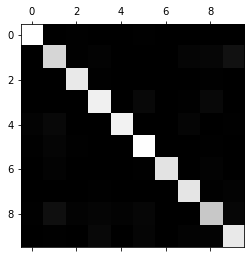

In [274]:
## 绘制混淆矩阵
cfm = confusion_matrix(y_test,y_predict) #存储混淆矩阵
plt.matshow(cfm, cmap=plt.cm.gray) ## 灰度矩阵：越亮代表数值越大，越暗代表数值越小

In [276]:
row_sums = np.sum(cfm,axis=1)  #计算每行都有多少个样本（在列的方向上求和）
err_matrix = cfm / row_sums
np.fill_diagonal(err_matrix,0) # 将对角线的都为0
err_matrix

array([[0.        , 0.        , 0.00735294, 0.        , 0.        ,
        0.00657895, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00735294, 0.01342282, 0.        ,
        0.        , 0.        , 0.02205882, 0.02857143, 0.06802721],
       [0.        , 0.        , 0.        , 0.00671141, 0.        ,
        0.        , 0.        , 0.        , 0.00714286, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03289474, 0.        , 0.00735294, 0.03571429, 0.        ],
       [0.01342282, 0.03496503, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.02205882, 0.        , 0.00680272],
       [0.00671141, 0.02097902, 0.00735294, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00714286, 0.        ],
       [0.        , 0.01398601, 0.        , 0.        , 0.        ,
        0.00657895, 0.        , 0.        , 0.01428571, 0.        ],
       [0.        , 0.        , 0.       

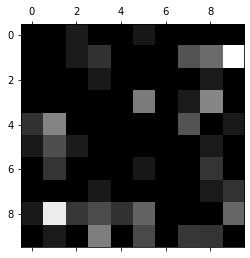

In [277]:
plt.matshow(err_matrix, cmap=plt.cm.gray) 
## 越亮的地方就是犯错越多的地方，行是真值，列是预测值
## 这样我们就可以清楚的看到在哪里犯的错误多，进而对算法进行改进。

#### 上图表明我们很容易混淆1和9，也很容易混淆1和8，因此我们可以做出调整，微调1和8分类器以及1和9分类器这两个二分类器的threshold值，来提高多分类问题的准确度。

#### 当使用机器学习预测的结果不准确时，有可能不是算法的问题，而是数据的问题，我们可以回到数据中，整理数据、提取更好的特征。

# 支撑向量机SVM Support Vector Machine

#### 既可以解决分类问题，又可以解决回归问题

不适定问题：决策边界不唯一

逻辑回归怎么解决不适定问题？？定义一个sigmoid函数，根据函数进行建模，形成损失函数

![title](../img/47.png)

#### d 是支撑向量到决策边界的距离
什么样的决策边界的泛化能力比较好呢？？

离直线最近的点，需要让这些点离直线的距离尽可能的远。

这条直线需要离两个类别的点都尽可能的远，还要准确地区分开两类。

#### SVM 要最大化margin , SVM解决的线性可分的问题（hard margin SVM）
Hard Margin SVM ：我们确实找到一个决策边界，这个决策边界没有错误的把左右的样本点进行了划分，同时最大化了margin

Soft Margin SVM : 数据不是线性可分的，改进Hard Margin SVM

![title](../img/48.png)

![title](../img/49.png)

### 分子||w||d是一个数

![title](../img/50.png)

### 再另w=w_d，b=b_d , 注意此时的w就跟原来推导前的w理论上不是同一个

![title](../img/51.png)

![title](../img/52.png)

样本空间任意点x到超平面（w,b）的距离为|w_T *x +b| / ||w||

![title](../img/53.png)

#### 上图表示Hard Margin SVM 
#### 大于等于1表示：所有的样本点必须在两个支撑向量外，两个支撑向量里面没有任何的样本点。
#### 无条件的最优化问题很好求解，另导数为0即可。但是有条件的最优化问题的求解比较复杂

# Soft Margin SVM 和 SVM的正则化

#### 当样本数据中有一个outlier时，会对SVM决策边界的划分产生很大的影响。

#### 我们需要思考，SVM划分的决策边界有一定的容错能力，它应该考虑到可以把一些样本数据进行错误分类，最终使得泛化能力尽可能高。

#### 还可能出现一种情况，数据本身是线性不可分的，这时使用Hard Margin SVM算法根本无法应用，无法得到结果。

#### 因此我们做出一个拥有容错能力的SVM，就是Soft Margin SVM

![title](../img/54.png)

在 Hard Margin SVM 中，我们要求所有的样本点必须在两个支撑向量外，两个支撑向量里面没有任何的样本点。

Soft Margin SVM ，给一个宽松条件。允许样本点可以出现在虚线与支撑向量之间。

#### 加入超参数C，用来平衡两部分
#### C越大，容错空间越小。 当C趋向于无穷的时候，Soft Margin SVM就变成了Hard Margin SVM

### SVM的本质是求解下面的最优化问题

![title](../img/55.png)

# scikit-learn 中的 SVM

使用SVM算法，和使用KNN算法一样，要做数据标准化处理！！！

涉及距离！！！

In [281]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()   
X = iris.data
y = iris.target

X = X[y<2, :2]   ##只取y=0/1的样本，只取该样本的前两个特征
y = y[y<2]

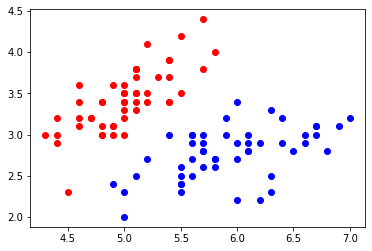

In [282]:
plt.scatter(X[y==0,0],X[y==0,1],color='red')
plt.scatter(X[y==1,0],X[y==1,1],color='blue')

In [283]:
## 数据标准化
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
standardScaler.fit(X)
X_standard = standardScaler.transform(X)

In [284]:
from sklearn.svm import LinearSVC
svc = LinearSVC( C=1e9 )  ##C越大，容错空间越小
svc.fit(X_standard,y)

LinearSVC(C=1000000000.0)

In [285]:
## 绘制决策边界
def plot_decison_boundary(model,axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])

    plt.contourf(x0, x1, zz, cmap=custom_cmap)

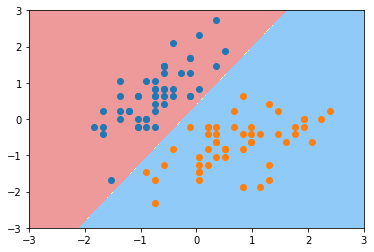

In [286]:
plot_decison_boundary(svc,axis=[-3,3,-3,3])
plt.scatter(X_standard[y==0,0],X_standard[y==0,1])
plt.scatter(X_standard[y==1,0],X_standard[y==1,1])

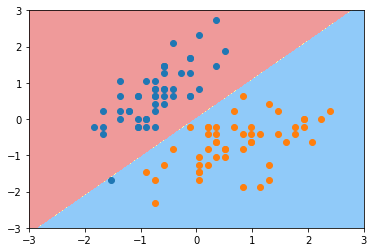

In [287]:
## 减小C，增大了容错空间
svc2 = LinearSVC( C=0.01 ) 
svc2.fit(X_standard,y)

plot_decison_boundary(svc2,axis=[-3,3,-3,3])
plt.scatter(X_standard[y==0,0],X_standard[y==0,1])
plt.scatter(X_standard[y==1,0],X_standard[y==1,1])

In [288]:
svc.coef_   ## 查看系数，样本中有两个特征就有两个系数

array([[ 4.03241038, -2.50699267]])

In [289]:
svc.intercept_

array([0.92736815])

In [290]:
def plot_svc_decison_boundary(model,axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])

    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    
    ##绘制两条支撑向量
    w = model.coef_[0]
    b = model.intercept_[0]
    #  w0 * x0 + w1 * x1 +b = 0
    #  x1 =  -w0/w1 * x0 - b/w1
    #  每给出一个x0，就可以找到一个x1
    plot_x = np.linspace(axis[0],axis[1],200)
    up_y = -w[0]/w[1] * plot_x - b/w[1] + 1/w[1]  ##上面的直线w0 * x0 + w1 * x1 +b = 1
    down_y = -w[0]/w[1] * plot_x - b/w[1] - 1/w[1]  ## 下面的直线w0 * x0 + w1 * x1 +b = -1
    
    ## 简单过滤，使得两条支撑向量不超过定义的坐标轴
    up_index = (up_y >= axis[2]) & (up_y <= axis[3])
    down_index = (down_y >= axis[2]) & (down_y <= axis[3])
   
    plt.plot(plot_x[up_index] , up_y[up_index] , color='black')
    plt.plot(plot_x[down_index] , down_y[down_index] , color='black')

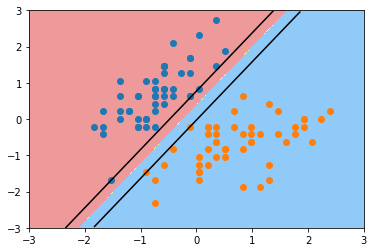

In [291]:
## 此时的svc 是 Hard Margin SVM
plot_svc_decison_boundary(svc,axis=[-3,3,-3,3])
plt.scatter(X_standard[y==0,0],X_standard[y==0,1])
plt.scatter(X_standard[y==1,0],X_standard[y==1,1])

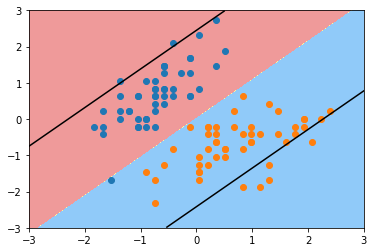

In [292]:
## 此时的svc 是 Soft Margin SVM
plot_svc_decison_boundary(svc2,axis=[-3,3,-3,3])
plt.scatter(X_standard[y==0,0],X_standard[y==0,1])
plt.scatter(X_standard[y==1,0],X_standard[y==1,1])

### SVM 中使用多项式特征（来处理非线性数据）

In [294]:
from sklearn import datasets
X,y = datasets.make_moons() 
X.shape,y.shape

((100, 2), (100,))

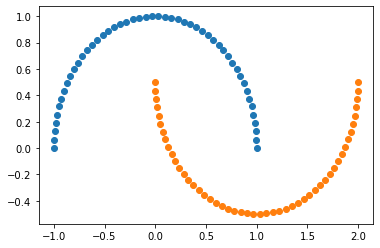

In [296]:
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [297]:
## 加入扰动 ,0.15 可以理解为标准差
X,y = datasets.make_moons( noise=0.15 , random_state=666) 

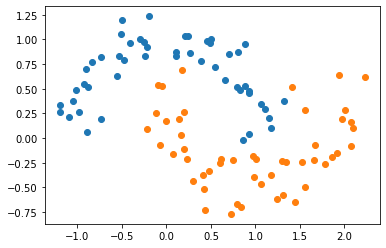

In [298]:
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [301]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

def PolynomialSVC(degree,C=1.0):
    return Pipeline([
        ('poly',PolynomialFeatures(degree=degree)), # 生成多项式特征
        ('std_scaler',StandardScaler()),  # 标准化
        ('linearSVC',LinearSVC(C=C))      
    ])

In [302]:
poly_svc = PolynomialSVC(degree=3)
poly_svc.fit(X,y)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('std_scaler', StandardScaler()), ('linearSVC', LinearSVC())])

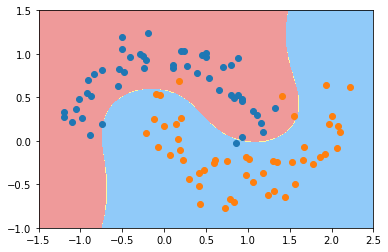

In [303]:
plot_decison_boundary(poly_svc,axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

# 使用多项式核函数的SVM

In [306]:
from sklearn.svm import SVC
def PolynomialKernelSVC(degree,C=1.0):
    return Pipeline([
        ('std_scaler',StandardScaler()),
        ('kernelSVC',SVC(kernel='poly',degree=degree ,C=C))  ##引入，多项式核函数，可以达到多项式特征的SVM的效果
    ])

In [307]:
poly_kernel_svc = PolynomialKernelSVC(degree=3)
poly_kernel_svc.fit(X,y)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('kernelSVC', SVC(kernel='poly'))])

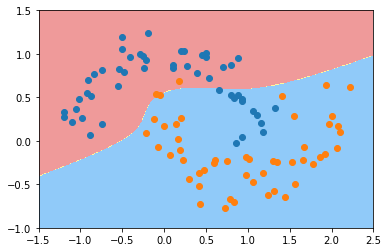

In [309]:
plot_decison_boundary(poly_kernel_svc,axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

# 什么是核函数？

#### SVM的本质是求解下面的最优化问题。

在求解左边的最优化问题的过程中，我们还是需要将它转变为右边这个更好求解的最优化问题

![title](../img/56.png)

#### 核函数：把低维空间的样本数据，映射到高维空间

（它的作用与多项式特征差不多）。核函数不只在SVM中使用，机器学习的其他地方也可以使用。

![title](../img/57.png)

![title](../img/58.png)

![title](../img/59.png)

#### 注：c 和 d 是两个超参数（c对应超参数coef0=0默认为0）
#### 线性核函数K(x,y)表示x 和 y 的点乘 

# 高斯核函数（SVM算法使用最多的核函数）

#### 本质是将每一个样本点映射到一个无穷维的特征空间

![title](../img/60.png)

#### 高斯核函数只有一个超参数γ
#### 高斯函数就是正态分布函数，u是均值，σ是标准差
#### 而高斯核函数就是去掉高斯函数前面的系数

### 高斯核函数又叫RBF核函数

回顾：
多项式特征：依靠升维使得原本线性不可分的数据变得线性可分。

高斯中的y不取样本点，而是取两个固定的点L_1和L_2（也叫地标landmark），来当做y。

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
## 测试用例
x = np.arange(-4,5,1)
x

array([-4, -3, -2, -1,  0,  1,  2,  3,  4])

In [12]:
### 做一个线性不可分的数据
y = np.array((x>=-2)&(x<=2),dtype='int')
y

array([0, 0, 1, 1, 1, 1, 1, 0, 0])

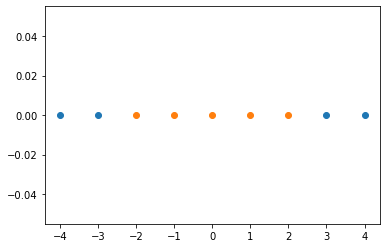

In [15]:
plt.scatter(x[y==0],[0]*len(x[y==0]))
plt.scatter(x[y==1],[0]*len(x[y==1]))
plt.show()

In [16]:
## 使用高斯核函数，把一维数据映射到二维空间
def gaussian(x,l):
    gamma = 1.0
    return np.exp(-gamma * (x-l)**2)

In [20]:
l1,l2 = -1,1

X_new = np.empty((len(x),2))
for i,data in enumerate(x):         ##data用于存储数据，i用于存储索引
    X_new[i,0] = gaussian(data ,l1)
    X_new[i,1] = gaussian(data ,l2)
X_new

array([[1.23409804e-04, 1.38879439e-11],
       [1.83156389e-02, 1.12535175e-07],
       [3.67879441e-01, 1.23409804e-04],
       [1.00000000e+00, 1.83156389e-02],
       [3.67879441e-01, 3.67879441e-01],
       [1.83156389e-02, 1.00000000e+00],
       [1.23409804e-04, 3.67879441e-01],
       [1.12535175e-07, 1.83156389e-02],
       [1.38879439e-11, 1.23409804e-04]])

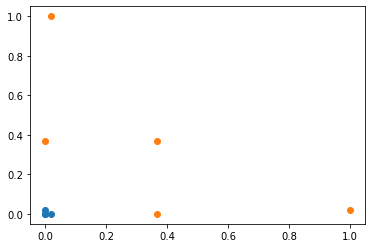

In [21]:
plt.scatter(X_new[y==0,0],X_new[y==0,1])
plt.scatter(X_new[y==1,0],X_new[y==1,1])
plt.show()

上面的例子中，我们把高斯核函数中的y的取值固定位两个点l1\l2


实际上y的取值的个数可以等于样本数

#### 高斯核函数的本质是：m*n的数据映射成了m*m的数据。如果样本数量很大的话，高斯核函数就是把原本的数据映射到了无穷维的空间。

#### 高斯核函数使用：适用于特征多，但数据样本少的情况。即m<n。适用于自然语言处理。

# scikit-learn中的高斯核函数

高斯核函数中的γ= 1/2σ**2

σ是标准差，σ越小数据分布越集中，高斯分布越窄；σ越大数据分布越分散，高斯分布越宽。

对于γ，γ越大高斯分布越窄，γ越小，高斯分布越宽。

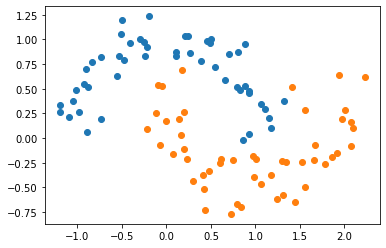

In [23]:
from sklearn import datasets
X,y = datasets.make_moons(noise=0.15,random_state=666)
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

def RBFKernelSVC(gamma=1.0):
    return Pipeline([
        ("std_scaler",StandardScaler()),
        ("svc",SVC(kernel="rbf", gamma=gamma))
    ])

In [26]:
svc = RBFKernelSVC(gamma=1.0)
svc.fit(X,y)

Pipeline(steps=[('std_scaler', StandardScaler()), ('svc', SVC(gamma=1.0))])

In [27]:
## 绘制决策边界
def plot_decison_boundary(model,axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])

    plt.contourf(x0, x1, zz, cmap=custom_cmap)

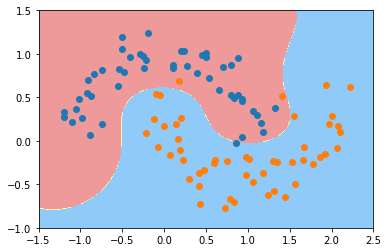

In [28]:
plot_decison_boundary(svc,axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

In [34]:
#### 增大gamma的值,即减小标准差，高斯分布变窄，泛华能力低
svc_gamma10 = RBFKernelSVC(gamma=10)
svc_gamma10.fit(X,y)

Pipeline(steps=[('std_scaler', StandardScaler()), ('svc', SVC(gamma=10))])

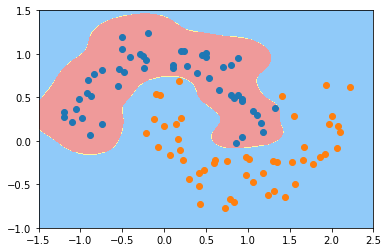

In [35]:
plot_decison_boundary(svc_gamma10,axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

# 使用SVC思想解决回归问题

在margin中包含的样本数据越多越好

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

#### LinearSVC 是使用线性SVM的思路来解决分类问题
#### LinearSVR 是使用线性SVM的思路来解决回归问题

In [6]:
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def StandardLinearSVR(epsilon=0.1):
    return Pipeline([
        ("std_scaler",StandardScaler()),
        ("LinearSVR",LinearSVR(epsilon=epsilon))
    ])


In [7]:
svr = StandardLinearSVR()
svr.fit(X_train,y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('LinearSVR', LinearSVR(epsilon=0.1))])

In [8]:
svr.score(X_test,y_test)

0.6358381002688631